In [1]:
import os
import sys
import torch
from torch.utils.data import random_split, DataLoader
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append(os.path.abspath(os.path.join('..', 'mycnn')))

from audio_cnn_model import AudioCNNModel
from audio_predictor import Predictor
from audio_trainer import Trainer
from drum_dataset import DrumDataset
from drum_label_map import DrumLabelMap

Total samples: 36
Training samples: 29
Validation samples: 7
Using device: cuda
Epoch 1/30 - Train Loss: 1.5078, Val Loss: 1.1848, Val Accuracy: 0.5714
Epoch 2/30 - Train Loss: 1.1131, Val Loss: 0.8202, Val Accuracy: 0.8571
Epoch 3/30 - Train Loss: 0.7317, Val Loss: 0.6630, Val Accuracy: 0.8571
Epoch 4/30 - Train Loss: 0.5796, Val Loss: 0.4942, Val Accuracy: 0.8571
Epoch 5/30 - Train Loss: 0.4640, Val Loss: 0.5347, Val Accuracy: 0.8571
Epoch 6/30 - Train Loss: 0.3386, Val Loss: 0.5930, Val Accuracy: 0.8571
Learning rate reduced from 0.001 to 0.0005
Epoch 7/30 - Train Loss: 0.4107, Val Loss: 0.9621, Val Accuracy: 0.7143
Epoch 8/30 - Train Loss: 0.3165, Val Loss: 1.2157, Val Accuracy: 0.5714
Epoch 9/30 - Train Loss: 0.2236, Val Loss: 0.9926, Val Accuracy: 0.5714
Learning rate reduced from 0.0005 to 0.00025
Epoch 10/30 - Train Loss: 0.1306, Val Loss: 1.0213, Val Accuracy: 0.7143
Epoch 11/30 - Train Loss: 0.1480, Val Loss: 0.9830, Val Accuracy: 0.7143
Epoch 12/30 - Train Loss: 0.1630, Val 

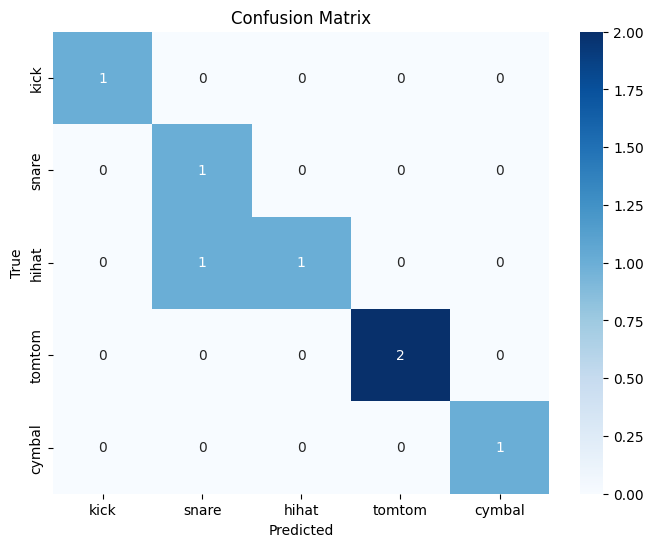

In [2]:
# --------- Utility Functions ---------

def create_data_loaders(audio_dir, batch_size=8, val_split=0.2):
    dataset = DrumDataset(audio_dir)
    total_samples = len(dataset)
    val_size = int(val_split * total_samples)
    train_size = total_samples - val_size

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, dataset

def save_model(model, path):
    torch.save(model.state_dict(), path)

def plot_confusion_matrix(labels, preds, class_names=None):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

# --------- Main Script ---------

# Create output directory if it doesn't exist
os.makedirs("../out/classifier", exist_ok=True)

# Set directories
audio_dir = "../data/samples"

# Create data loaders
train_loader, val_loader, dataset = create_data_loaders(audio_dir, batch_size=8)

print(f"Total samples: {len(dataset)}")
print(f"Training samples: {len(train_loader.dataset)}")
print(f"Validation samples: {len(val_loader.dataset)}")

# Choose device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create model
model = AudioCNNModel(num_classes=len(DrumLabelMap.categories)).to(device)

# Run a single batch through the model to initialize FC layers
if len(train_loader) > 0:
    sample_batch = next(iter(train_loader))
    sample_inputs = sample_batch["input"].to(device)
    with torch.no_grad():
        _ = model(sample_inputs)
else:
    raise RuntimeError("No training data found. Cannot initialize model.")

# Train model
trainer = Trainer(model, train_loader, val_loader, device=device)
all_preds, all_labels = trainer.train(num_epochs=30)

# Plot confusion matrix
plot_confusion_matrix(all_labels, all_preds, class_names=DrumLabelMap.categories)

# Save the trained model
save_model(model, "../out/classifier/drum_classifier_model.pth")


In [3]:
# Why does this not work?
# =======================

# Example prediction
example_files = ["../data/samples/snare/snare_1.wav",
                 "../data/samples/kick/kick_1.wav",
                 "../data/samples/hihat/hihat_open_1.wav",
                 "../data/samples/hihat/hihat_closed_1.wav"]

for example_file in example_files:
    print(f"Predicting for: {example_file}")
    if os.path.exists(example_file):
        predictor = Predictor(model)
        prediction, probabilities = predictor.predict(example_file)
        print(f"Predicted drum type: {prediction}")
        for category, prob in sorted(probabilities.items(), key=lambda x: x[1], reverse=True):
            print(f"{category}: {prob:.4f}")
    else:
        print(f"Example file not found: {example_file}")

Predicting for: ../data/samples/snare/snare_1.wav
Predicted drum type: tomtom
tomtom: 1.0000
kick: 0.0000
snare: 0.0000
hihat: 0.0000
cymbal: 0.0000
Predicting for: ../data/samples/kick/kick_1.wav
Predicted drum type: tomtom
tomtom: 1.0000
kick: 0.0000
snare: 0.0000
hihat: 0.0000
cymbal: 0.0000
Predicting for: ../data/samples/hihat/hihat_open_1.wav
Predicted drum type: tomtom
tomtom: 1.0000
kick: 0.0000
snare: 0.0000
hihat: 0.0000
cymbal: 0.0000
Predicting for: ../data/samples/hihat/hihat_closed_1.wav
Predicted drum type: tomtom
tomtom: 1.0000
snare: 0.0000
cymbal: 0.0000
hihat: 0.0000
kick: 0.0000
